## 2. Double check the blog to see that we get what they get by using our code and write out the analytical solution

We start off by translating their R code into python to ensure that we get the same results adn print the statistics to better understand their VAR model

/tmp/ipykernel_510834/1548942665.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_table(url, skiprows=6, delim_whitespace=True)
/tmp/ipykernel_510834/1548942665.py:20: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  data.index = pd.date_range(start='1960-01-01', periods=len(data), freq='Q')


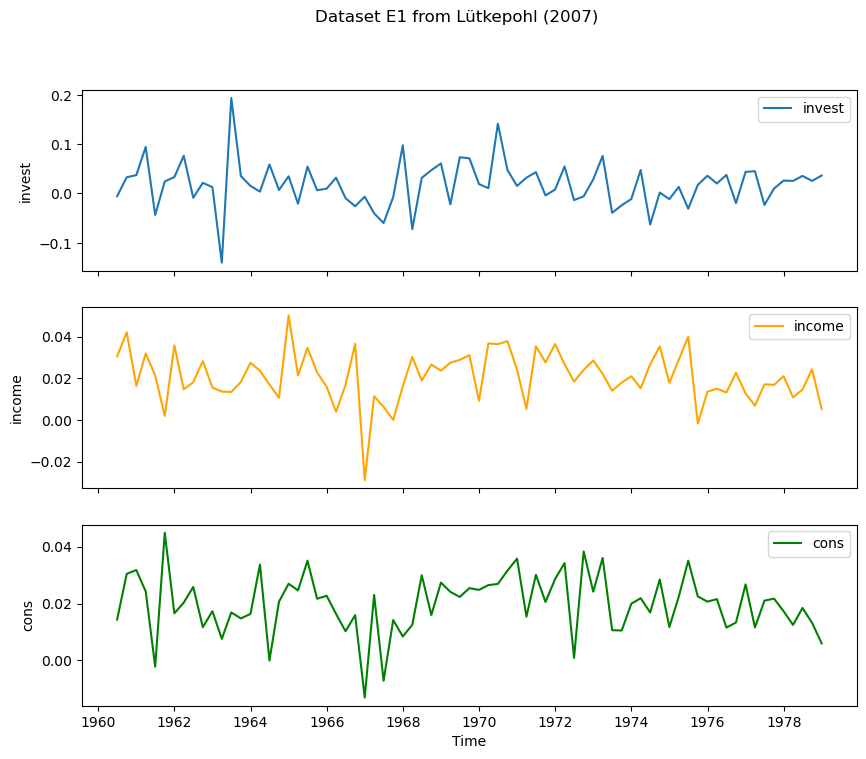

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 04, Sep, 2024
Time:                     11:35:41
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -23.8905
Nobs:                     73.0000    HQIC:                  -24.2869
Log likelihood:           606.307    FPE:                2.18315e-11
AIC:                     -24.5494    Det(Omega_mle):     1.65876e-11
--------------------------------------------------------------------
Results for equation invest
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const            -0.016722         0.017226           -0.971           0.332
L1.invest        -0.319631         0.125456           -2.548           0.011
L1.income         0.145989         0.545666            0.268           0.78

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

# Download data
url = "http://www.jmulti.de/download/datasets/e1.dat"
data = pd.read_table(url, skiprows=6, delim_whitespace=True)

# Only use the first 76 observations
data = data.iloc[:76, :]

# Convert all columns to numeric
data = data.apply(pd.to_numeric, errors='coerce')

# Remove rows with zero or missing values to avoid log issues
data = data.dropna()

# Convert to time series object
data.index = pd.date_range(start='1960-01-01', periods=len(data), freq='Q')

# Take logs and differences
data_log_diff = np.log(data).diff().dropna()

# Fit VAR model
model = VAR(data_log_diff)
results = model.fit(2)

# Optionally, plot the data
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 8), sharex=True)

# Plot each series in its own subplot
axs[0].plot(data_log_diff.index, data_log_diff['invest'], label='invest')
axs[0].set_ylabel('invest')
axs[0].legend()

axs[1].plot(data_log_diff.index, data_log_diff['income'], label='income', color='orange')
axs[1].set_ylabel('income')
axs[1].legend()

axs[2].plot(data_log_diff.index, data_log_diff['cons'], label='cons', color='green')
axs[2].set_ylabel('cons')
axs[2].legend()

# Set the title and x-axis label
fig.suptitle("Dataset E1 from Lütkepohl (2007)")
plt.xlabel('Time')

# Show the plot
plt.show()

# Print summary statistics
print(results.summary())

We want to express this as 

$$ y_t = c + A_1y_{t-1} + A_2y_{t-2} + \epsilon_t $$

with A1​:
$$
A_1 = \begin{pmatrix}
-0.319631 & 0.145989 & 0.961219 \\
0.043931 & -0.152732 & 0.288502 \\
-0.002423 & 0.224813 & -0.263968
\end{pmatrix},
$$
A2​:
$$
A_2 = \begin{pmatrix}
-0.160551 & 0.114605 & 0.934394 \\
0.050031 & 0.019166 & -0.010205 \\
0.033880 & 0.354912 & -0.022230
\end{pmatrix},
$$
c:
$$
c = \begin{pmatrix}
-0.016722 \\
0.015767 \\
0.012926
\end{pmatrix},
$$
and $\epsilon$
$$
\epsilon_t = \begin{pmatrix}
\epsilon_{1t} \\
\epsilon_{2t} \\
\epsilon_{3t}
\end{pmatrix}
$$


With these matrices we can calculate the IRF explicitly according to the formula

$$
\Phi_i = \sum_{j=1}^{i} \Phi_{i-j} A_j, \quad i = 1, 2, \dots
$$

with $\Phi_0=I_K$ and $A_j=0$ for $j>p$, where K is the number of endogenous variables and p is the lag order of the VAR model

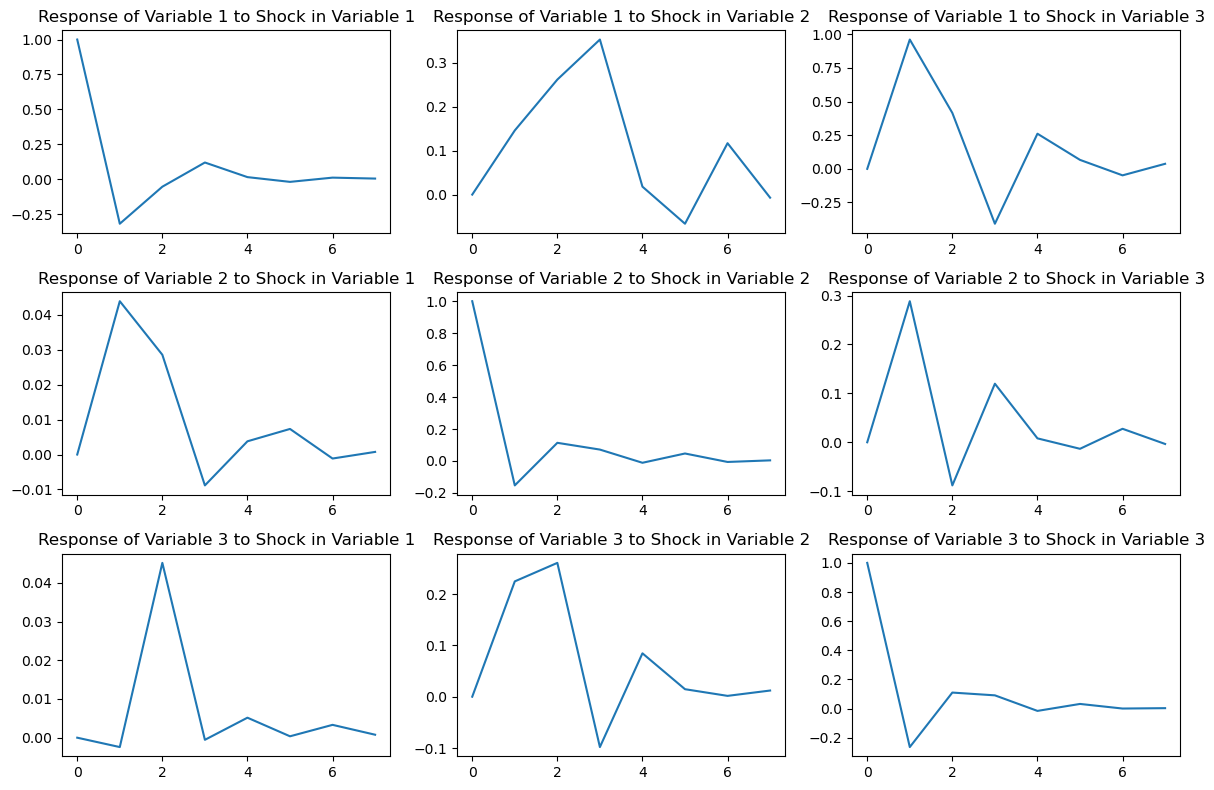

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Define the A1 and A2 matrices (from the regression results)
A1 = np.array([[-0.319631, 0.145989, 0.961219],
               [0.043931, -0.152732, 0.288502],
               [-0.002423, 0.224813, -0.263968]])

A2 = np.array([[-0.160551, 0.114605, 0.934394],
               [0.050031, 0.019166, -0.010205],
               [0.033880, 0.354912, -0.022230]])

# Identity matrix for initial shock
I = np.eye(3)

# Time periods for which we want the IRFs
n_periods = 8

# Initialize Phi matrices (impulse responses)
Phi = np.zeros((n_periods, 3, 3))
Phi[0] = I  # At t=0, the response is just the shock itself

# Calculate Phi matrices using recursive formula
for t in range(1, n_periods):
    if t == 1:
        Phi[t] = A1
    elif t == 2:
        Phi[t] = np.dot(A1, Phi[1]) + A2
    else:
        Phi[t] = np.dot(A1, Phi[t-1]) + np.dot(A2, Phi[t-2])

# Plot the impulse response functions
fig, axs = plt.subplots(3, 3, figsize=(12, 8))

for i in range(3):
    for j in range(3):
        axs[i, j].plot(range(n_periods), [Phi[t][i, j] for t in range(n_periods)])
        axs[i, j].set_title(f"Response of Variable {i+1} to Shock in Variable {j+1}")

plt.tight_layout()
plt.show()


We note that in the paper, they add a shock to income (variable 2) and plot the IRF for cons (variable 3). To ensure that we are getting the same as them, we add their (python converted) plot

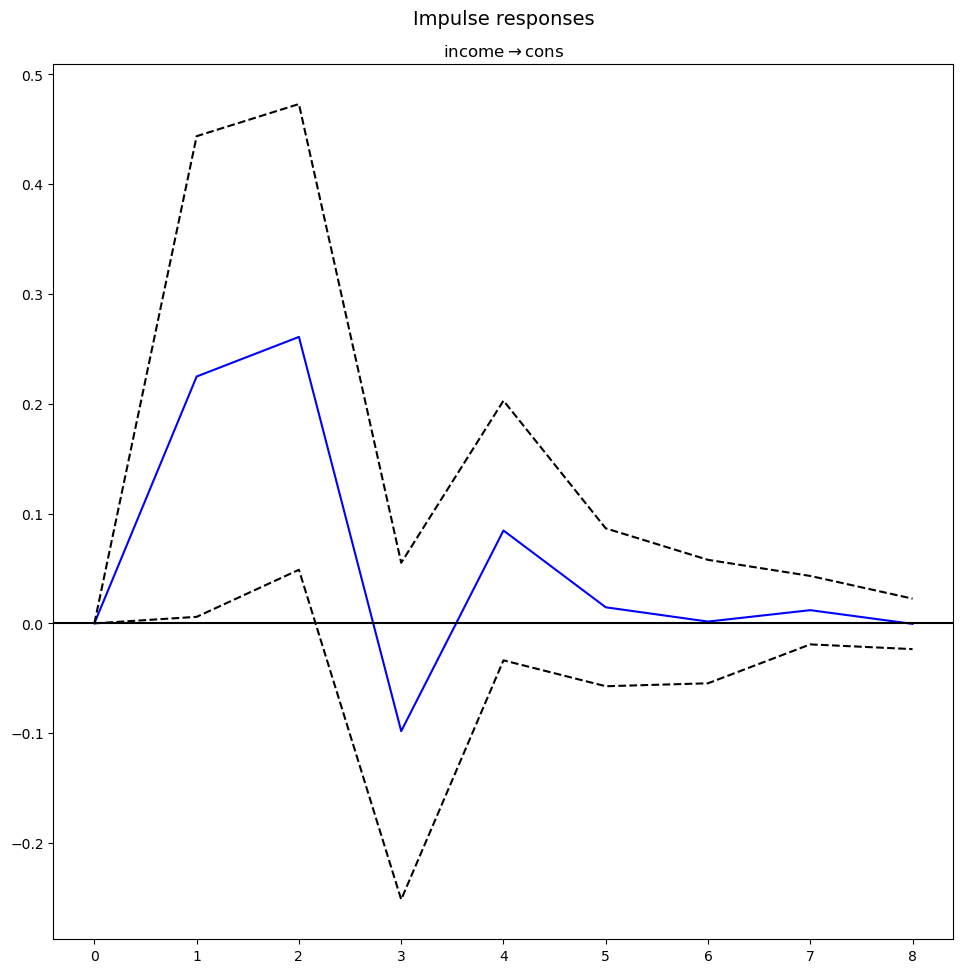

In [10]:
# Impulse response function (IRF) analysis
irf = results.irf(8)  
# Plot IRF
irf_fig = irf.plot(impulse='income', response='cons', orth=False)
plt.show()  



Which (aside form the confidence intervals and the added noise from the addtional runs) seems to be the same that we got. We note that they, in the article, even perform a Cholesky decomposition and plot the Orthogonal impulse response functions. 

Q2: Are we interested in either? Thus far I have not done anything concerning this. 

Variance-Covariance Matrix of Residuals:
           invest    income      cons
invest  0.002130  0.000072  0.000123
income  0.000072  0.000137  0.000061
cons    0.000123  0.000061  0.000089
Cholesky Decomposition (P):
 [[0.0461479  0.         0.        ]
 [0.00155189 0.01161591 0.        ]
 [0.00267055 0.00493412 0.00759777]]


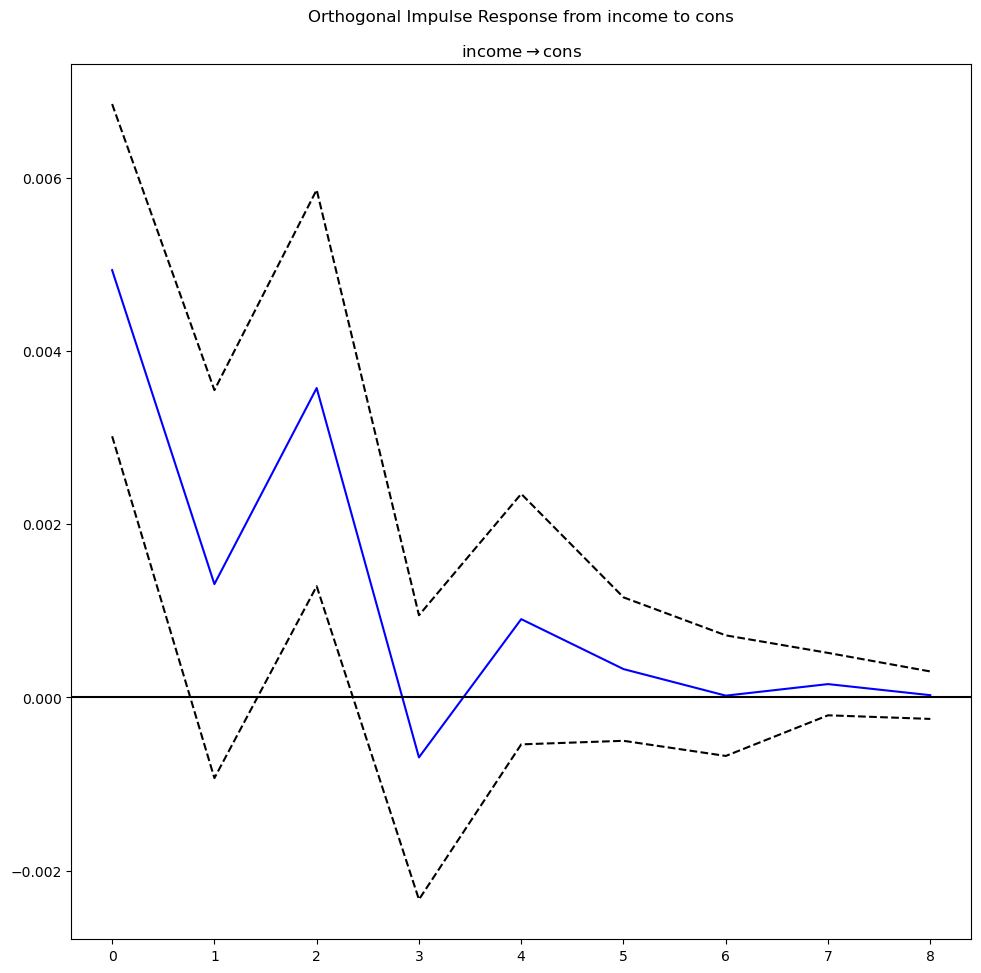

In [12]:
# Obtain variance-covariance matrix of the residuals
cov_matrix = results.sigma_u
print("Variance-Covariance Matrix of Residuals:\n", cov_matrix)

from numpy.linalg import cholesky
# Perform Cholesky decomposition
P = cholesky(cov_matrix)
print("Cholesky Decomposition (P):\n", P)


# Impulse response function (IRF) analysis
irf = results.irf(8)  

# Plot Orthogonal Impulse Response Functions with confidence intervals. Set orth=True
fig = irf.plot(impulse='income', response='cons', orth=True)
plt.suptitle('Orthogonal Impulse Response from income to cons')
plt.show()

Short remark on stability. For a Vector Autoregressive process of order p, VAR(p) can be written as

$$ X_t = A_1X_{t-1} + A_2 X_{t-2} + ... + A_p X_{t-p} + \epsilon_t $$

For the VAR process to be stationary, its mean and variance must be constant over time, and the covariance between values of the series must depend only on the time difference. Stationarity thus imply that shocsks to the system should have bounded effect over time, rather than causing the system to diverge. To see this, let

$$ \mathbf{Z}_t = \begin{pmatrix}
    \mathbf{X}_t \\
    \mathbf{X}_{t-1} \\
    \vdots \\
    \mathbf{X}_{t-p+1}
\end{pmatrix}
$$